In [42]:
import numpy as np
from numpy.fft import fft2, ifft2
from PIL import Image, ImageOps, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import measure
from collections import defaultdict
import cv2
from scipy.ndimage import convolve
import string

CHARS = string.ascii_lowercase + string.digits + "?!.,"

# OCR - Optical Character Recognition

Spis treści:
- ...
- ...

# Założenia

- Tekst składa się z małych liter alfabetu łacińskiego oraz cyfr.
- Na obrazie występuje jeden typ i rozmiar czcionki.
- Występują znaki przestankowe:   .  ,  !  ?
- Tekst składa się z wielu linii.
- Tekst może być obrócony.
- Program pownien zwracać tekst wraz ze znakami białymi i znakami nowej linii.
- Program powinien zliczać liczbę wystąpień każdego znaku.

TODO:
- SZERYFOWE I NIE SZERYFOWE -> porównaj
- może raportować % poprawności dla predefiniowanych testów

# Wczytywanie obrazu

Obraz wczytuję za pomocą biblioteki PIL i konwertuję go na skalę szarości

In [43]:
def load_image(filepath, invert=True):
    if invert:
        return ImageOps.invert(Image.open(filepath).convert('L'))
    return Image.open(filepath).convert('L')

# Wczytywanie czcionek

Do mojego programu przygotowałem dwa zestawy czcionek: 
- szeryfową (times new roman)
- nie szeryfową (sans-serif)  

In [44]:
def load_fonts(fontname, fontsize):
    return ImageFont.truetype(f'fonts/{fontname}.ttf', fontsize)

# Tworzenie obrazu z tekstem

Do utworzenia obrazu z tekstem używam biblioteki PIL. Tworzę obraz o wymiarach 1000x1000 pikseli, a następnie dodaję na nim tekst.  
Przy ewentualnych argumentach obraz może być obrócony o dany kąt i/lub nałożony na niego szum.

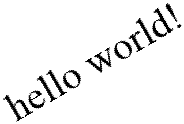

In [139]:
def draw_text(text, font_name, font_size, rotate=0, noise=0, inverted=False):
    def add_noise(img, noise):
        img = np.array(img)
        noise = np.random.normal(0, noise, img.shape)
        noisy = img + noise
        noisy = np.clip(noisy, 0, 255)
        return Image.fromarray(noisy.astype(np.uint8))
    font = load_fonts(font_name, font_size)
    length = int((max([font.getlength(line) for line in text.split('\n')])+10)*1.1)
    img = Image.new('L', (length, 1000), color='black')
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), text, font=font, fill='white')
    cropped = img.crop(img.getbbox())
    rotated = cropped.rotate(rotate, expand=1)
    reversed = ImageOps.invert(rotated)
    padded = ImageOps.expand(reversed, border=1, fill='white')
    noised = add_noise(padded, noise)
    if inverted:
        return ImageOps.invert(noised)
    return noised

draw_text("hello world!", 'times-new-roman', 40, rotate=30)

# Obrót obrazu

Wykrywam najmniejszy prostokąt, który zawiera tekst i obracam go tak, aby był prostokątem o bokach równoległych do osi układu współrzędnych:
- jeśli jest skierowany w górę to ustawiam kąt na przeciwny
- jeśli jest skierowany w dół to ustawiam kąt na dopełnienie 90 stopni

In [46]:
def rotate_image(img):
    gray = np.array(img)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    p1, p2, angle = cv2.minAreaRect(coords)

    if p1[1] < p2[1]:
        angle = -angle
    else:
        angle = 90 - angle
    return img.rotate(angle, expand=1, fillcolor=255, resample=Image.BICUBIC)

# Usuwanie szumu

Do usuwania szumu wykorzystuję interpolację dwuwymiarową. Dla każdego piksela obliczam średnią z jego sąsiadów z otoczenia o rozmiarze 3x3 o poniżych współczynnikach.

In [47]:
def remove_noise(image):
    display(image)
    img = np.array(image)
    kernel = np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]], dtype=np.float64)
    kernel /= kernel.sum()
    smooth_data = convolve(img, kernel)
    return Image.fromarray(smooth_data.astype(np.uint8))

# Dodanie wszystkich znaków do obrazu 

Aby mieć pewność, że znak został rozpoznany, dodaję do obrazu wszystkie wzorce znaków z wybranego zestawu czcionek, które będą porównywane z obrazem wejściowym. Dzięki temu dodane wzorce powinny mieć największe wartości korelacji, właśnie z tą wartością będę porównywał obraz wejściowy.

In [48]:
def add_char_patterns(image, font, fontsize):
    patterns = draw_text(CHARS, font, fontsize, noise=0, inverted=True)
    result = Image.new('L', (max(image.width, patterns.width), image.height + patterns.height), 0)
    result.paste(image, (0, 0))
    result.paste(patterns, (0, image.height))
    return np.array(result)

# Korelacja

In [49]:
def correlation(image, sample):
    return np.real(ifft2(np.multiply(fft2(np.array(image)), fft2(np.rot90(sample, 2), np.array(image).shape))))

# Zaznaczanie znalezionych znaków

In [50]:
def highlight_matches(image, pattern, char, matches, ratio=10):
    fig, ax = plt.subplots(figsize=(image.shape[0]//ratio, image.shape[1]//ratio))
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{char} - {len(matches)} found')
    for x, y in matches:
        ax.add_patch(patches.Rectangle((y, x), -pattern.shape[1], -pattern.shape[0], edgecolor='r', facecolor='none'))
    plt.show()

# Kolejność wykrywania znaków

Kolejność wykrywania znaków ustalam na podstawie odwrotnej listy liczby wykrytych znaków w obrazie zawierającym wszystkie znaki - skoro z daną pewnością wykryłem pewien znak więcej niż jeden raz to jest większa szansa na pomylenie go w obrazie wejściowym.

Głównym powodem takiego stanu jest podobieństwo niektórych znaków, np. 'i' i 'l', oraz zawieranie się niektórych znaków w innych, np. 'c' w 'e'.

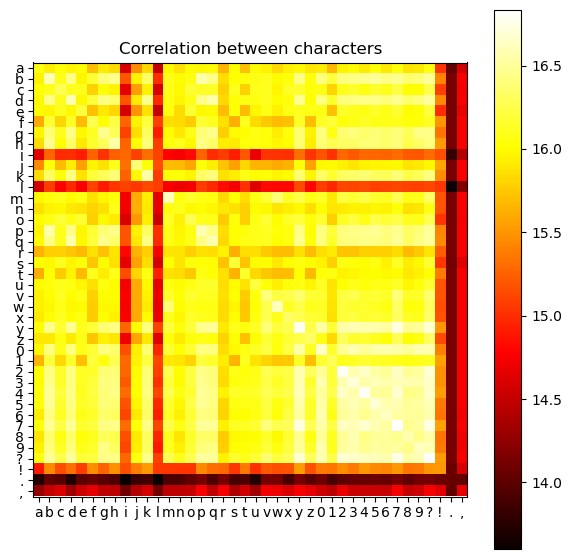

In [51]:
def correlation_heatmap(font):
    heatmap = [[np.log(correlation(draw_text(char1, font, 30), draw_text(char2, font, 30)).max()) for char2 in CHARS] for char1 in CHARS]
    plt.figure(figsize=(7, 7))
    plt.yticks(range(len(CHARS)), CHARS)
    plt.xticks(range(len(CHARS)), CHARS)
    plt.title('Correlation between characters')
    plt.colorbar(plt.imshow(heatmap, cmap='hot'))
    plt.show()

correlation_heatmap('sans-serif')

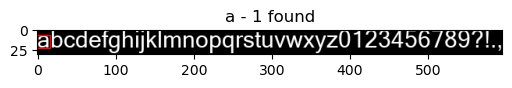

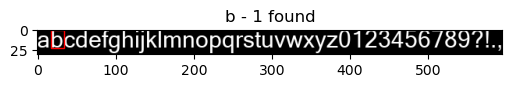

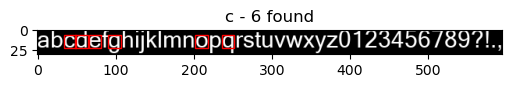

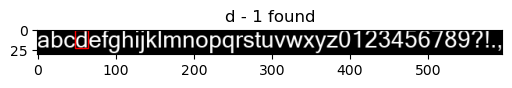

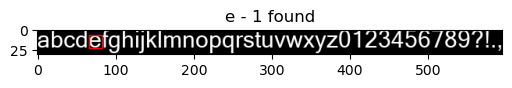

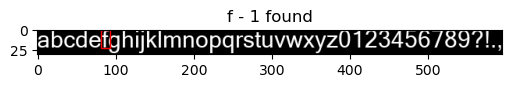

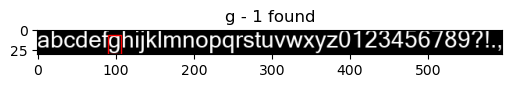

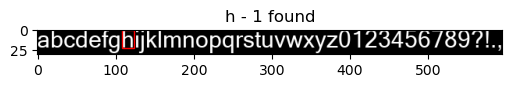

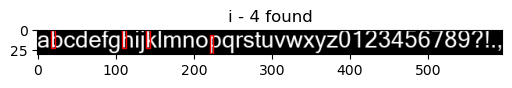

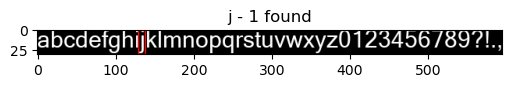

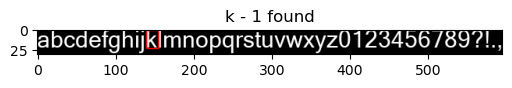

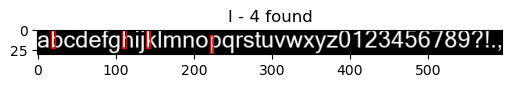

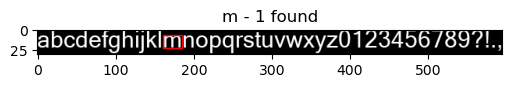

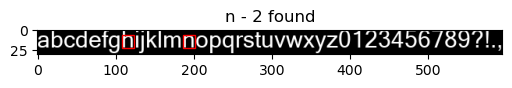

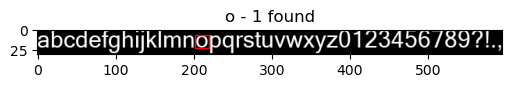

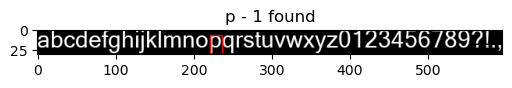

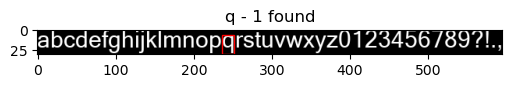

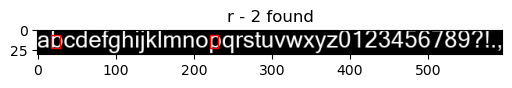

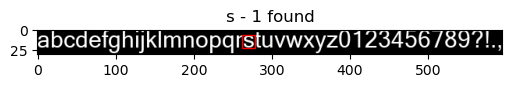

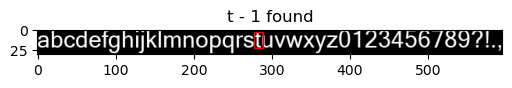

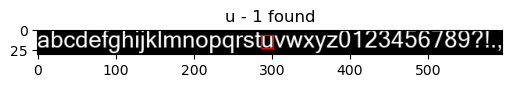

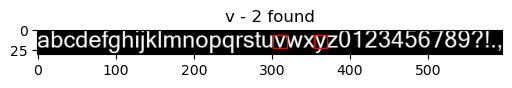

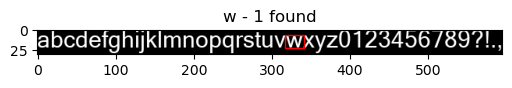

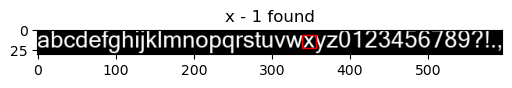

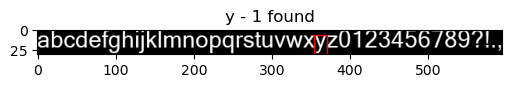

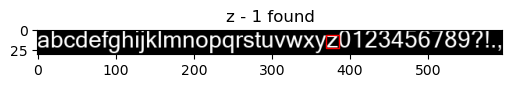

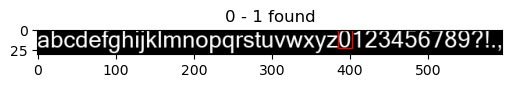

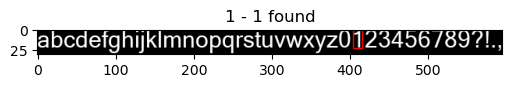

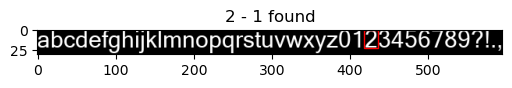

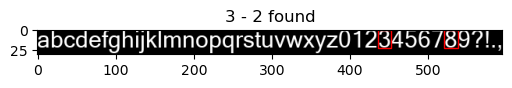

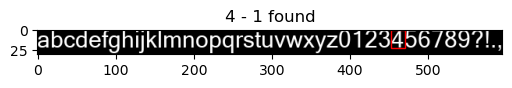

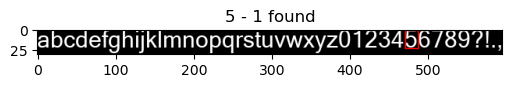

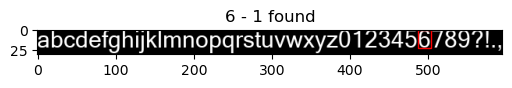

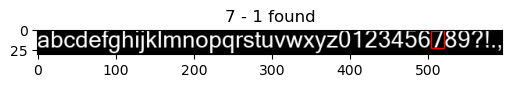

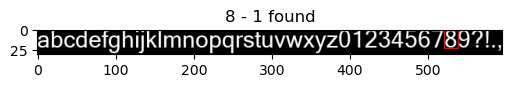

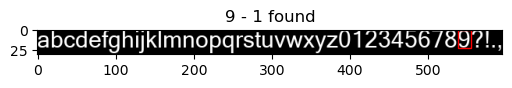

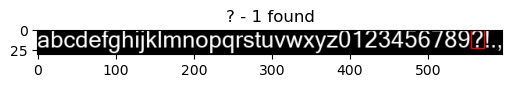

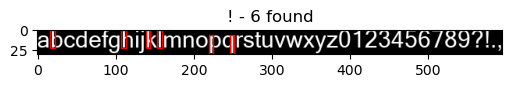

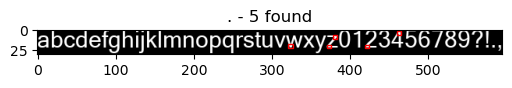

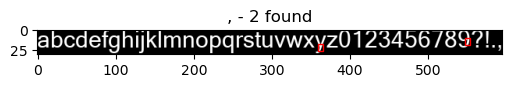

['a',
 'h',
 'd',
 'e',
 'f',
 'g',
 'b',
 'j',
 'k',
 'm',
 'p',
 'q',
 's',
 't',
 'o',
 'n',
 'w',
 'x',
 'y',
 'z',
 '0',
 '1',
 '2',
 '4',
 '6',
 '5',
 '7',
 '8',
 '9',
 'u',
 'r',
 'v',
 '3',
 'l',
 'i',
 'c',
 '?',
 '!',
 '.',
 ',']

In [174]:
def get_char_order(font, confidence=0.99, ratio=5, show=False):
    counter_dict = defaultdict(list)
    background = np.array(draw_text(CHARS, font, font_size=30, inverted=True))

    for char in CHARS:
        sample = np.array(draw_text(char, font, font_size=30, inverted=True))
        img_cor = correlation(background, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        count = len(measure.find_contours(img_cor, confidence*np.max(img_cor)))
        counter_dict[count].append(char)
    
        if show:
            _, ax = plt.subplots(figsize=(background.shape[0]//ratio, background.shape[1]//ratio))
            ax.set_title(f'{char} - {count} found')
            ax.imshow(background, cmap='gray')
            for i, j in np.argwhere(img_cor!=0.):
                ax.add_patch(patches.Rectangle((j,i), -sample.shape[1], -sample.shape[0], edgecolor='r', facecolor='none'))
            plt.show()
    
    return ['a', 'h', 'd', 'e', 'f', 'g', 'b', 'j', 'k', 'm', 
            'p', 'q', 's', 't', 'o', 'n', 'w', 'x', 'y', 'z',
            '0', '1', '2', '4', '6', '5', '7', '8', '9', 'u',
            'r', 'v', '3', 'l', 'i', 'c', '?', '!', '.', ',']


get_char_order('sans-serif', show=True)

# Wykrywanie znaków

In [144]:
def read_text(image, font, fontsize, confidence=0, show=False):
    if confidence == 0:
        if fontsize <= 20: confidence = 0.98
        elif fontsize <= 30: confidence = 0.99
        else: confidence = 0.99
    char_order = get_char_order(font, show)
    enchanced = add_char_patterns(image, font, fontsize)
    positions = []
    for char in char_order:
        if char in ['.']:
            confidence = 0.95
        sample = np.array(draw_text(char, font, fontsize, inverted=True))
        img_cor = correlation(enchanced, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        if show:
            highlight_matches(enchanced, sample, char, np.argwhere(img_cor!=0.))
        for i, j in np.argwhere(img_cor!=0.):
            for x in range(1, sample.shape[0]):
                for y in range(1, sample.shape[1]):
                    enchanced[i-x, j-y] = 0
            positions.append((i, j, char))

    return positions       

# Podział na linie

In [54]:
def line_division(positions, font, fontsize):
    lines = defaultdict(list)
    lineheight = draw_text('a', font, fontsize).height
    for y, x, char in positions:
        for line in lines.keys():
            if abs(y - line) < lineheight:
                lines[line].append((x, char))
                break
        else:
            lines[y] = [(x, char)]
    
    return [line for _, line in sorted(lines.items())][:-1]

# Podział na słowa

In [66]:
def word_division(lines, font, fontsize):
    text = ""
    space = load_fonts(font, fontsize).getlength(' ') * 0.7
    for line in lines:
        prev_x = min(line)[0]
        for i, (x, char) in enumerate(sorted(line)):
            if i > 0 and x - prev_x - draw_text(char, font, fontsize).width >= space:
                text += ' '
            text += char
            prev_x = x
        text += '\n'
        
    return text

# OCR

In [120]:
def ocr(image, font, fsize=40, confidence=0, isnoised=False, isrotated=False, show=False):
    if isnoised: image = remove_noise(image)
    if isrotated: image = rotate_image(image)
    image = ImageOps.invert(image)
    ready = image.crop(image.getbbox())
    display(ready)
    positions = read_text(ready, font, fsize, confidence=confidence, show=show)
    lines = line_division(positions, font, fsize)
    return word_division(lines, font, fsize)

# Testowanie

Do przetestowania poprawności działania programu wykorzystałem kryterium dystansu Levenshteina.  
[wikipedia/levenstein_distance](https://en.wikipedia.org/wiki/Levenshtein_distance)

In [ ]:
def levenshtein_distance(expected, result):
    matrix = np.zeros((len(result)+1, len(expected)+1))
    for i in range(1, len(result)+1):
        for j in range(1, len(expected)+1):
            sub_cost = 0 if result[i-1] == expected[j-1] else 1
            matrix[i, j] = min(matrix[i-1, j] + 1, 
                               matrix[i, j-1] + 1, 
                               matrix[i-1, j-1] + sub_cost)
    return (len(expected)-matrix[-1, -1]) / len(expected) * 100

In [175]:
def test(expected, font, fontsize, confidence=0, noise=0, rotate=0 ):
    image = draw_text(expected, font, fontsize, noise=noise, rotate=rotate)
    display(image)
    result = ocr(image, font, fontsize, confidence=confidence, isnoised=noise>0, isrotated=rotate!=0, show=False)
    print("Expected:")
    print(expected)
    print("Result:")
    print(result)
    result = result[:-1]
    print(f'Levenshtein result: {levenshtein_distance(expected, result)}%') 

# Rezultaty

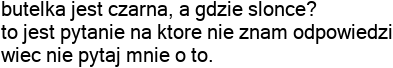

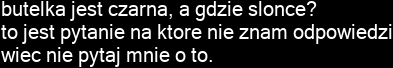

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
hx jjwtabae bats4jj ttjjjjjjjjjjjjae99!!!!gae aeyedxjjjjjjjjjjjjba tsbeguutt tao
? ! t 7 ?
jijte bats4jj ey j0jaeguuba guuae kjijte0ta guuba jjjjjjjjjjjjguuaeg66 tedxeyteqqybadxjjjjjjjjjjjj33
! i 8
qqybatt guuba ey j0jae g66guuba te jijte
l i ! j lljjjjjjj
aehxttdxtajjyeh44 k8g66guuteeyyemjj85 lqqxvjjjjjjjjjjjj2totjjjjjjjotjqj1fftncte !!ftpgwo!!

Levenshtein result: 12.962962962962962%


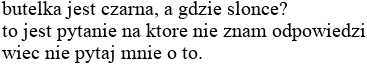

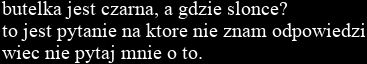

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
l l
httte k l e aa tt tdaa ot 2
u aaa aaat f aaa t aaa
t ajftt66 a aaaa66ttttt66 66 aaaa!taaaj7a jvtttt9aa
c
!
eol epttte t l t tteot t l aat odpotttt daa
aaat aaa aaa aaa aaa
v a ! 66tttt9ja tttt66 ftt vta tttt9ja aaatttt6 jmv tz! vwja!taaaj7
ttt t ttt
tttt ttte e
aaa t laaa p n aaa o o
wjaa tttt9ja ! ? jmmja v v
ttt t
l a e aaaaa y
h d a bnk qt ettttttttttjttttaa01 ttt4tttt 5 y
aaa f f t u i taaaa g xx
66 a tzaaaaaattttj fttj jmm 3 t t wttt aaa tttaaaaac 8

Levenshtein result: 22.22222222222222%


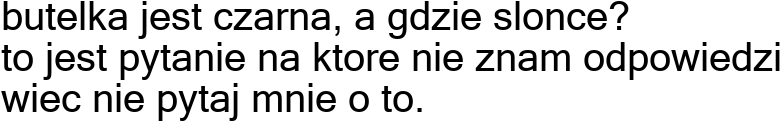

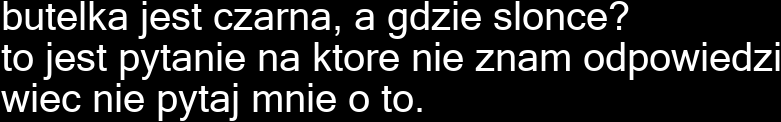

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
jjjjjj
jjb4jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjje ffkijjjjjjjjjjja jjjjjjjjjjjjjjjjjjjjjjjjjjjjejjjjjjjjjjjjjjjjjjjjjjjj jjjjjjjjjjjjljjjjjjjjijjijjijjijjjjijjjjjjjjjjjatjjjjjj0ijjjjjjjjjjja ijjjjjjjjjjja jg jdjjjjjjjjjjzjjjjjjjjjjjjjj3jjjjjjjjjjjjjjjjjjjjjjjjjjjje jjjjjjjjjjjjjj ejjjjjxjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjje7
jjjjj jjjjj jjjjjjjj cjjjjjj jj jjjjjj jjjjjjjjj jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj 0jjjjjj jjjjjj jjjjjjjjjjj jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj jjjjjj jjjjjjj jjjjjj11 jjjjjj jjjjjj
jjjjjj88jjjje jjjjjjjjjjjjjjjjjjjjjjjjjjjjejjjjjjjjjjjjjjjjjjjjjjjj jjjjjjjj?ttjjjjjjjjjjwwijjjjjjjjjjjajjjjj0 jjjjjjjjjjjjjjjjjjjjjjjjjjjje jjjjj0ijjjjjjjjjjja ffkjjjjjjjjjjetjjjjjjjjjjjjjjjjjjjjjjjjjjjjje jjjjj0 jjjjjjjjjjjjjjjjjjjjjjjjjjjje jjjjjjljjjjjjjjijjijjijjijjjjjjjjj0ijjjjjjjjjjjajjjjjjjj e jdjjjjjjjj?ejjjpjj1jjjjjjjjjjjjjjjjjjjjjjjjjjjje jdjjj

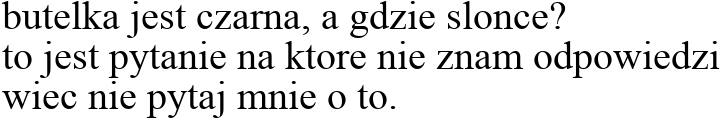

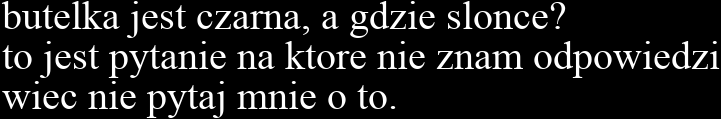

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
ttttttt tt tt ttttttt tttt
t tttt t tttt ttttttttttt
ttttttttttttttttt tt ttttttttt tttttttttttt tttttttttttt tt tt
tttttthtttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttkttttttttttt ttttttttttttttttttttttttttttttttttttttttttttt ttttttt tttttttttttttttttttttttttttttttttttttttttttpttttttttttt ttttttttttt tttttttttgtttt ttttttd ttttttttttttttttttttttttttttttttttttttttttt tttttttt tttttttttttttttttttttttttttttttt tttttttttttttttttttttttttt ttt
tttttttt ttttttttttttttttttttt ttttttt ttttt ttttttttt tttttttttttt?tttt tttttt ttttttt ttttttttt ttttttttttttttttt ttttt ttttttttttttt tttttttt ttttttt ttttttttt tttttttttttt?tttttttttttt tttttttttttt ttttt ?
tt tttttt t tt ttt ttt tt tt ttt ttttt tt tt tttt ttt tttt tt tt
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttfttttttttttttttttttttttttttttt3 tttttttttttttttttttttttttttittttttt tt

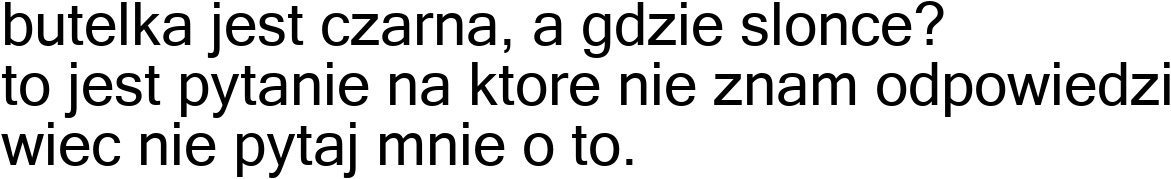

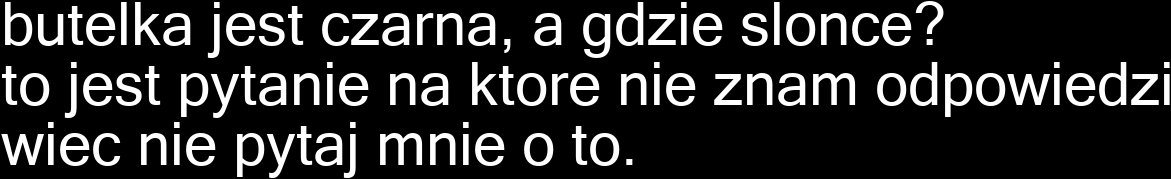

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
jjjjjjjti
b4jjjjjjjjjjjjj3jjjjjjljjljjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjje fkitjjjjjjjjjjjjjjjjjjjjjjjjjjjjj ljjljjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjejjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjijjjjjjjjjj iiijjjjjjjjjjjjjjjjjjjtjjjtjjjtjjjjjjjjjtjjjtjjjtjjjtjjjtjjjtjjjtjjjtjjjtjjjjjjjjjitjjjjjjjjjjjjjjjjjjjjjjjjjjjjjljjjjjjjjjjjjjjjjjjjjjjjitjjjjjjjjjjjjjjjjjjjjjjjjjjjjj itjjjjjjjjjjjjjjjjjjjjjjjjjjjjj iii jgiii jdjjjjjjjjjjjjtjjjtjjjtjjjjjjjjjtjjjtjjjtjjjtjjjtjjjtjjjtjjjtjjjtjjjjjjjjj ljjljjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjje jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj iiiejjjjjjjjjjjjjjjjjjiiixjjjjjjjljjljjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjeltttttii
jjjjjjjjj jjjjjjjjjjjjjjjjjjjjjijjjjjjjj nijjjjjjjjjj ijjjjjjjj jjjjjjjjj jjjj jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjijjjjjjjjjj 2ijjjjjjjjjj! ijjjjjjjjjj jjjj

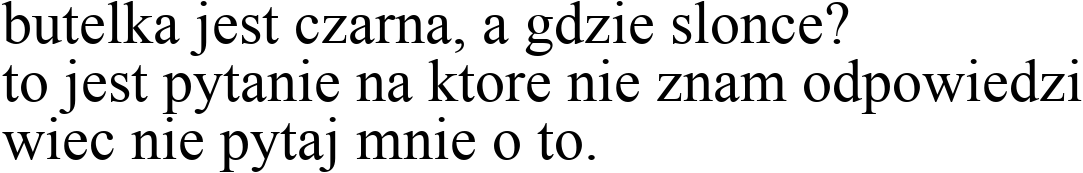

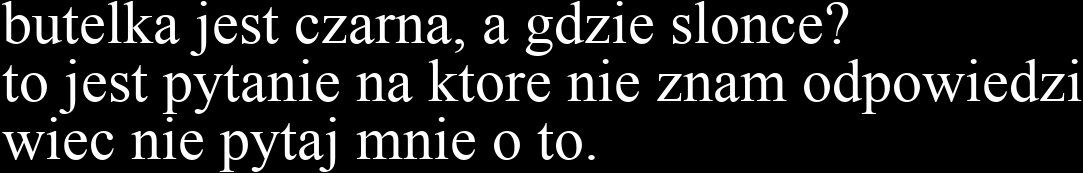

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
tttttttttttttttttttttt tttttttttt tttttttttt tttttttttttttttttttttt tttttttttttttttttttttttt
tttt tttttttttttttttttt tttt tttttttttttttttttt tttttttttttttttttttttttttttttttttttt
tttttttttttttttttttttttttttttttttttttttt ttttttttt ttttttttt ttt tttttttt ttttttttttttttttttttttttttttt ttttttttttttttttttttttttttttttttttttt ttttt ttttttttt ttttttttt ttttttttttttttttttttttt tttttttt tttttttttttttttttttt ttttttttt tttttttt tttttttt tttttttt
ttttttttttttttt ttttttttttttttttbtttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttkttttttttttttttttttttttttttttttttttttttttttttttttttt ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

In [98]:
text = "butelka jest czarna, a gdzie slonce?\n" \
       "to jest pytanie na ktore nie znam odpowiedzi\n" \
       "wiec nie pytaj mnie o to.\n" 
for size in [20, 40, 60]:
    for font in ['sans-serif', 'times-new-roman']:
        test(text, font, size)

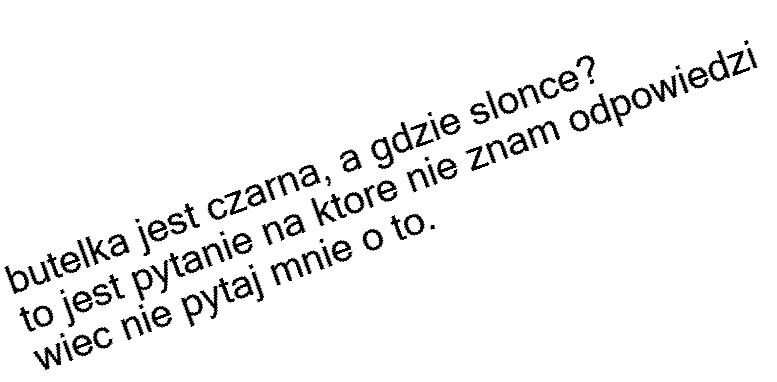

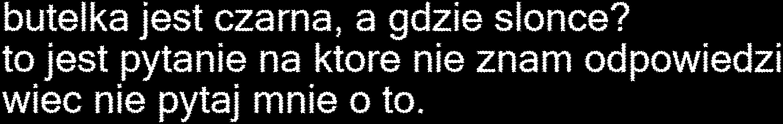

Expected:
butelka jest czarna, a gdzie slonce?
to jest pytanie na ktore nie znam odpowiedzi
wiec nie pytaj mnie o to.

Result:
bbutelka jest czarna, a gdzie sllonce?
to jest pytaniie na ktore nie znam odpowwiiedzi
wiiec niie pytaj mnie o to.

Levenshtein result: 93.51851851851852%


In [178]:
test(text, 'sans-serif', 40, noise=0, rotate=20, confidence=0.93)

Widać, że program działa poprawnie. Ale większych czcionek (>=30) lepiej sobie radzi z czcionkami bezszeryfowymi, a mniejszych z szeryfowymi.

---